In [3]:
from rsv_utils import add_syn_mut_attribute, add_changes_from_root_attr, DateToStr
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, date
import calendar
import time
import math
import json
import string
import requests

### Find nonsynonymous and synonymous divergence in different genes and plot the ratio of dN/dS

In [2]:
def get_measles_genome_info():
    """
    Read in the reference file and generate dictionaries that store sequence and position information for the functions below
    """
    # make dictionary with gene name as key and reference sequence of that gene as value
    reference_sequence_aa = {}
    reference_sequence_nt = {}

    # make dictionary giving gene by genomic location
    reference_gene_locations = {}

    # make dictionary saying what codon within the gene a certain genomic location falls within
    # and whether the mutation is at pos 0, 1 or 2 within codon
    reference_gene_codon = {}

    for record in SeqIO.parse(open(f"../../measles/config/measles_reference.gb","r"), "genbank"):
        genome_seq = record.seq
        for feature in record.features:
            if feature.type == 'CDS':
                # allow RdRp to overwrite Orf1a and Orf1b,
                # to take care of changed reading frame due to  ribosome slippage
                # S1 and S2 will also overwrite spike
                for pos in range(int(feature.location.start), int(feature.location.end)):
                    reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                    codon_num = math.floor((pos-feature.location.start)/3)
                    pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                    reference_gene_codon[pos] = (codon_num, pos_in_codon)

                gene_seq = feature.location.extract(record.seq)
                reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
                gene_seq_aa = gene_seq.translate()
                reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

    # make dictionary with length of each gene
    gene_lengths_aa = {k:len(v) for k,v in reference_sequence_aa.items()}
    
    return reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa


In [4]:
#Get information about gene locations for Measles

reference_sequence_nt, reference_sequence_aa, reference_gene_locations, reference_gene_codon, gene_lengths_aa = get_measles_genome_info()


In [9]:
def get_tree():
    """
    Read in the tree and add an attribute to each node listing synonymous mutations
    """
    
    #all genes in the genome
    gene_list = list(gene_lengths_aa.keys())
    
    tree_json_file = f'../../measles/auspice/measles.json'
    
    with open(tree_json_file, 'r') as f:
        tree_json = json.load(f)

    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    #add synonymous mutations as an attribute of the tree
    tree = add_syn_mut_attribute(tree, reference_gene_locations, 
                                 reference_gene_codon,
                                 reference_sequence_nt, 
                                 reference_sequence_aa)
    
    #add an attribute to each node that lists all mutations that have occurred between the root and node
    tree = add_changes_from_root_attr(tree, gene_list)
    
    return tree

In [10]:
tree_measles = get_tree()

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.9/site-packages/Bio/Seq.py:2749: BiopythonDeprecationWarning: myseq.toseq() is deprecated; please use Seq(myseq) instead.
  warnings.warn(


For each time window, compute dN/dS for each isolate within the window. For each internal branch, the following function finds gene-specific nonsynonymous and synonymous divergence and then calculates the dN/dS ratio. Divergence here is the Hamming distance from the root normalized by the total number of synonymous or nonsynonymous sites in the gene.

In [14]:
def find_nonsyn_syn_denominators():
    
    denominators = {}
    
    for gene,nt_seq in reference_sequence_nt.items():
        
        seq = str(nt_seq)
        aa_seq = str(reference_sequence_aa[gene])


        nonsyn_denominator = 0
        syn_denominator = 0

        all_nts = ['A', 'C', 'G', 'T']

        for pos in range(len(seq)):

            nt = seq[pos]
            if nt!='N':

                codon = math.floor(pos/3)
                codon_pos = pos-(codon*3)
                real_codon_aa = aa_seq[codon]

                all_other_nts = [x for x in all_nts if x != nt]
                for mutated_nt in all_other_nts: 
                    if codon_pos == 0:
                        mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                    elif codon_pos == 1:
                        mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                    elif codon_pos == 2:
                        mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                    mut_codon_aa = Seq(mut_codon_nt).translate()

                    if mut_codon_aa!=real_codon_aa:
                        nonsyn_denominator+=1
                    elif mut_codon_aa==real_codon_aa:
                        syn_denominator+=1
                        
            
        denominators[gene] = {'nonsyn_denominator': nonsyn_denominator, 'syn_denominator':syn_denominator}
        
    return denominators

Calculate the total number of nonsynonymous or synonymous sites (denominators)

In [15]:
denominators_measles = find_nonsyn_syn_denominators()

Time windows for Fig2 will be 2 calendar months, and human readable. Make a list of time window start and end dates, in human readable dates and decimal years. For plotting, use the date at the middle of the window. For example, if window includes all of March and April 2020 (Mar-01-2020 to Apr-30-2020), plot this at April 1 2020. Use sliding windows that overlap by one month

In [20]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [22]:
# find the start date and end date of the build

def get_build_dates():
    tree = tree_measles
    
    last_timepoint = 0
    first_timepoint = 2000
    for node in tree.find_clades():
        if node.node_attrs['num_date']['value'] > last_timepoint:
            last_timepoint = node.node_attrs['num_date']['value']
        if node.node_attrs['num_date']['value'] < first_timepoint:
            first_timepoint = node.node_attrs['num_date']['value']
    
    last_date = DateToStr(last_timepoint)
    last_date = datetime.strptime(last_date, '%b-%d-%Y')
    first_date = DateToStr(first_timepoint)
    first_date = datetime.strptime(first_date, '%b-%d-%Y')
    
    return first_date, last_date

In [23]:
def make_time_windows(window_size):
    """
    Make sliding windows of length `window_size` (in years) that are offset by 1 year
    """
    
    first_date, last_date = get_build_dates()
    
    time_windows = []

    for year in range(first_date.year, last_date.year-window_size):
        window_start = year
        window_end = year+window_size
        window_midpoint = (window_start+window_end)/2
        window_midpoint_str = DateToStr(window_midpoint)
     
        time_windows.append({'window_start_decimal': float(window_start), 
                             'window_end_decimal': float(window_end), 'window_midpoint_decimal': float(window_midpoint), 
                        'window_start': datetime.strptime(str(window_start), '%Y'), 
                        'window_end': datetime.strptime(str(window_end), '%Y'), 
                        'window_midpoint': datetime.strptime(window_midpoint_str, '%b-%d-%Y')})
                
    return time_windows

In [24]:
def find_divergence_in_window(gene_list, window_size=10):
    
    #make sliding time windows
    time_windows = make_time_windows(window_size)
    
    window_dnds_info = []
    
    tree = tree_measles
    
    
    # look at divergence within time window
    for x in range(0,len(time_windows)):
        start_date = float(time_windows[x]['window_start_decimal'])
        end_date = float(time_windows[x]['window_end_decimal'])
        
        nonsyn_div_in_window = []
        syn_div_in_window = []

        for node in tree.find_clades(terminal=False):
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                for gene in gene_list:
                    gene_nonsyn_denom = denominators_measles[gene]['nonsyn_denominator'] 
                    gene_syn_denom = denominators_measles[gene]['syn_denominator']
                    
                    #divergence accumulation
                    gene_nonsyn_divergence = len(node.branch_attrs["changes_from_root"]['nonsyn'][gene])/gene_nonsyn_denom
                    
                    #assign a false count to avoid dividing by zero
                    if len(node.branch_attrs["changes_from_root"]['syn'][gene]) == 0:
                        gene_syn_divergence = 1/gene_syn_denom
                    else:
                        gene_syn_divergence = len(node.branch_attrs["changes_from_root"]['syn'][gene])/gene_syn_denom

                    
                    
                    dn_over_ds = gene_nonsyn_divergence/gene_syn_divergence
                    
                    window_dnds_info.append({'window_start': time_windows[x]['window_start_decimal'],  
                                             'window_end': time_windows[x]['window_end_decimal'], 
                                             'window_midpoint': time_windows[x]['window_midpoint_decimal'], 
                                             'dn': gene_nonsyn_divergence, 'ds': gene_syn_divergence,
                                             'dn/ds':dn_over_ds, 'location': gene})

    window_dnds_df = pd.DataFrame(window_dnds_info)

        

    return window_dnds_df
        

In [25]:
dnds_df_measles= find_divergence_in_window(list(gene_lengths_aa.keys()))

In [26]:
mean_overall_H = dnds_df_measles[dnds_df_measles['location']=='H']['dn/ds'].mean()
print(f'Overall mean dn/ds in H: {mean_overall_H}')

mean_overall_F = dnds_df_measles[dnds_df_measles['location']=='F']['dn/ds'].mean()
print(f'Overall mean dn/ds in F: {mean_overall_F}')

mean_overall_L = dnds_df_measles[dnds_df_measles['location']=='L']['dn/ds'].mean()
print(f'Overall mean dn/ds in L: {mean_overall_L}')


Overall mean dn/ds in H: 0.08122809781457627
Overall mean dn/ds in F: 0.03259902934439259
Overall mean dn/ds in L: 0.04817272401043756


In [36]:
list(gene_lengths_aa.keys())

['N', 'P', 'V', 'C', 'M', 'F', 'H', 'L']

In [39]:
def plot_divergence_accumulation(filename=None):
    genes_to_plot = ['N', 'M', 'F', 'H', 'L']

    df_to_plot = dnds_df_measles[dnds_df_measles['location'].isin(genes_to_plot)]
    
    cmap = {'N':"#d90000", 'M': '#307358', 
            'H': "#F5AD52", 'F': '#1b7ced', 'L':"#8b0000"}

    fig = plt.figure(figsize=(8, 5))
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    #what to plot on what axis
    data_to_plot = {0: 'dn', 1: 'ds', 2: 'dn/ds'}
    y_axis_label = {0: 'dN', 1:'dS', 2:'dN/dS'}
    x_axis_label = {0: '', 1:'', 2:'date'}
    whether_to_plot_legend = {0: False, 1: False, 2:True}

    axs = [ax1,ax2,ax3]
    for k in range(len(axs)):
        sns.lineplot(x='window_start', y=data_to_plot[k], hue='location', 
                  data=df_to_plot, palette=cmap, linewidth=2, hue_order = ['H', 'F', 'L', 'N', 'M'],
                  ci=95, ax=axs[k], legend = whether_to_plot_legend[k])

        axs[k].set_xlabel(x_axis_label[k], fontsize=14)
        axs[k].set_ylabel(y_axis_label[k], fontsize=14)
        
        axs[k].tick_params(axis='both',labelsize=12)



    fig.suptitle(f'Measles divergence accumulation', fontsize=16)
    plt.tight_layout()
    sns.set_style("white")
    sns.despine(left=False, bottom=False)


    handles, labels = ax3.get_legend_handles_labels()
    lgd = ax3.legend(handles, labels, loc='upper center', fontsize=12, bbox_to_anchor=(1.1, 2.0), 
                             title = r'$\bf{Gene}$')
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

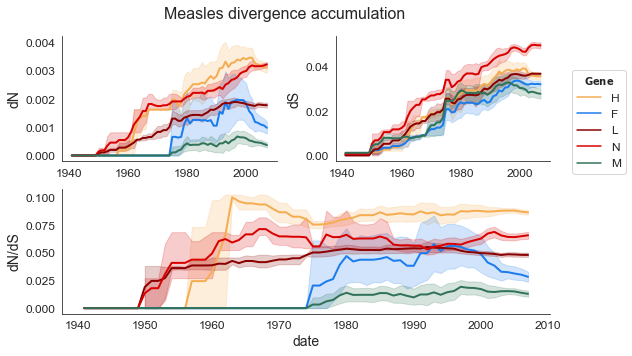

In [41]:
plot_divergence_accumulation('plots/Measles_divergence_accumulation.png')